In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from torch.optim import *
from IPython import display
import numpy as np
import random
from tqdm import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(precision=2, sci_mode=False)

In [8]:
class Belly(nn.Module):
    """
    Estimates a function using bell curves
    """
    
    def __init__(self, latent_dim, n=128):
        super().__init__()
        self.n = n
        self.bell_weights = nn.Linear(latent_dim, n)
        self.bell_coefs = nn.Linear(latent_dim, n)
        self.bell_exremum = nn.Linear(latent_dim, n)
    
    def forward(self, latent, input):
        """
        latent: [latent_dim]
        input: [batch_size, 1]
        """
        extremum = self.bell_exremum(latent) * (self.n ** .5) # [n]
        weights = self.bell_exremum(latent) # [n]
        coefs = self.bell_coefs(latent) #/ self.n # [n]
        
        input = input - extremum # [batch_size, n]
        input = input * weights # [batch_size, n]
        
        out = coefs * torch.exp(-input ** 2) # [batch_size, n]
        return out.sum(-1) # [batch_size]

    def extremum(self, latent):
        extremum = self.bell_exremum(latent)
        weights = self.bell_exremum(latent)
        coefs = self.bell_coefs(latent)
        
        bell_inputs = weights * (extremum[..., None] - extremum)
        out = torch.exp(-bell_inputs ** 2)
        return out

In [9]:
class BellEstimator(nn.Module):
    def __init__(self, latent_dim=128, n=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.n = n
        
        self.latent = nn.Parameter(torch.randn(latent_dim))
        self.bells = Belly(latent_dim, n=n)
    
    def forward(self, input):
        return self.bells(self.latent, input)

In [126]:
# model = BellEstimator(n=1024).to(device)
model = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

with torch.no_grad():
    for i in range(2, len(model) - 1, 2):
        weight = model[i].weight
        weight.mul_(.01)
        weight.add_(torch.eye(*weight.shape, device=device))
        
        model[i].bias.zero_()

optimizer = Adam(model.parameters(), lr=1e-5)

# square funtion
target_fn = lambda x: torch.floor(x) - 2 * torch.floor(x/2)

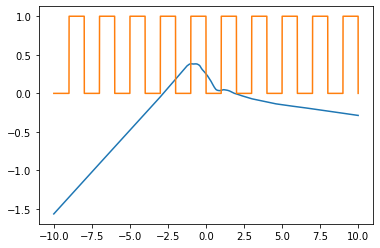

In [127]:
with torch.no_grad():
    x = torch.linspace(-10, 10, 10000, device=device).unsqueeze(1)
    # exs = model.bells.bell_exremum(model.latent).mul(model.n).cpu()
    y = model(x).cpu()
    x = x.cpu()

    fix, ax = plt.subplots()
    ax.plot(x, y)
    ax.plot(x, target_fn(x))
    
    # for x in exs:
    #     ax.axvline(x)

    plt.show()

In [130]:
# train model for sin curve

batch_size = 512
loss_fn = nn.MSELoss()
with tqdm(range(2000)) as pbar:
    for i in pbar:
        x = torch.randn(batch_size, 1, device=device)

        y = target_fn(x)
        y_hat = model(x)
        loss = loss_fn(y, y_hat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if -i % 50 == 1:
            pbar.set_description(f"loss={loss.item():.3f}")
    

loss=0.047: 100%|██████████| 2000/2000 [00:08<00:00, 228.75it/s]


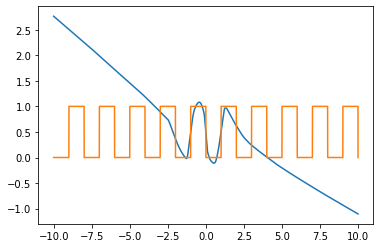

In [131]:
with torch.no_grad():
    x = torch.linspace(-10, 10, 10000, device=device).unsqueeze(1)
    # exs = model.bells.bell_exremum(model.latent).mul(model.n).cpu()
    y = model(x).cpu()
    x = x.cpu()

    fix, ax = plt.subplots()
    ax.plot(x, y)
    ax.plot(x, target_fn(x))
    
    # for x in exs:
    #     ax.axvline(x)

    plt.show()

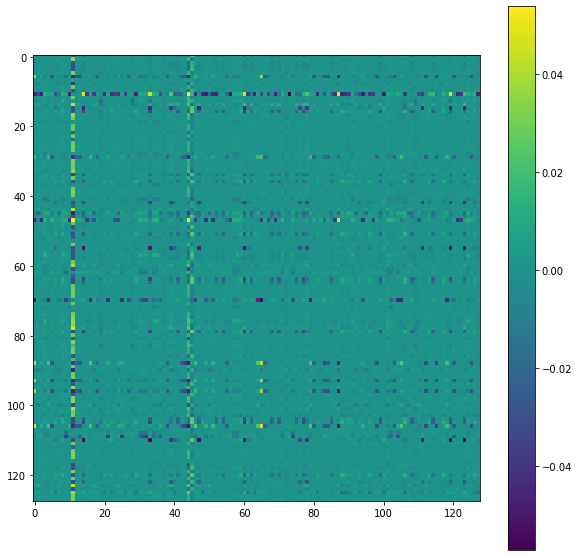

In [135]:
with torch.no_grad():
    fig, ax = plt.subplots(figsize=(10, 10))
    weights = model[4].weight.cpu()
    weights.fill_diagonal_(0)
    img = ax.imshow(weights)
    fig.colorbar(img)

plt.show()